# PyTorch Computer Vision

- See reference notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb
- See reference online book - https://www.learnpytorch.io/03_pytorch_computer_vision/

## 0. Computer vision labraries 

- [`torchvision`](https:/www.learnpytorch.io/03_pytorch_computer_vision/) - base domain library fpr PyTorch computer vision
- `torchvision.datasets` - get datasets and data loading functions for computer vision here
- `torchvision.models` - get pretrained computer vision models that you can levarage for your own problems
- `torch.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
- `torch.utils.data.Dataset` - Base dataset class for PyTorch
- `torch.utils.data.DataLoader` - Creates a python iterable over a dataset

In [2]:
# Import PyTorch

import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 2050


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting a dataset

the dataset we'll be using is FashionMNIST from the [`torchvision.datasets`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)

In [5]:
# Setup training data

train_data = datasets.FashionMNIST(
    root = "data", # where to download data to?
    train= True, # do we want the training dataset?
    download= True, # do we want to download yes/no ?
    transform= ToTensor(), # torchvision.transforms.ToTensor() also does the same thing. How do we want to transform the data?
    target_transform= None # how do we want to transform the labels/ targets
)

test_data = datasets.FashionMNIST(
    root = "data", # where to download data to?
    train= False, # do we want the training dataset?
    download= True, # do we want to download yes/no ?
    transform= ToTensor(), # torchvision.transforms.ToTensor() also does the same thing. How do we want to transform the data?
    target_transform= None # how do we want to transform the labels/ targets
)


In [6]:
len(train_data), len(test_data)

(60000, 10000)

### 1.1 Check input and output shapes of data.

In [7]:
# See the first training example
image, label = train_data[0]
print(f"Image shape: {image.shape} -> [color_channels, height, width] labels: {label}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width] labels: 9


In [8]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.2 Visualizing our data

In [10]:
import matplotlib.pyplot as plt

image, label = train_data[1]
print(f"Image shape: {image.shape}")
# plt.imshow(image) => doesn't work. gives error. try running and you'll understand the error.


Image shape: torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

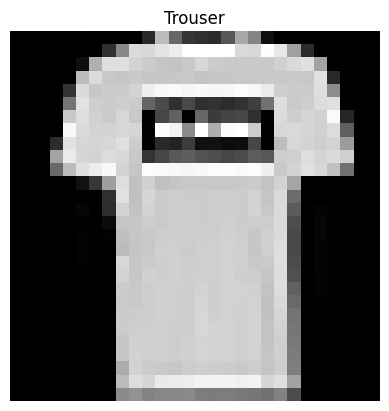

In [68]:
plt.imshow(image.squeeze(),cmap="gray") # matplotlib expects the image to be in color channel last format. but our data has color channel last. Here we have the grayscaled image whose color channel is 1 so we remove the color channel. if we had color channel that is greater than one we have to use permute.

plt.title(class_names[label])
plt.axis(False)

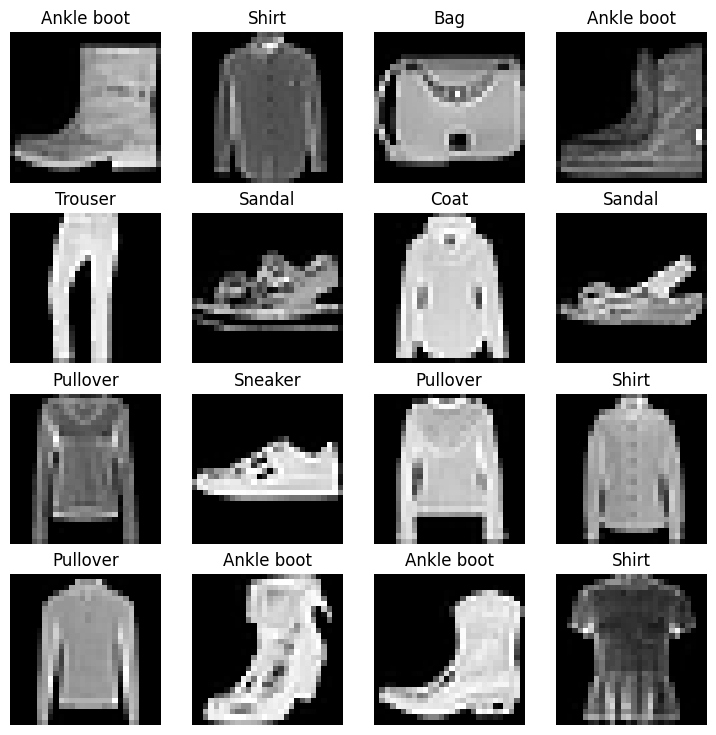

In [12]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx] # type: ignore
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

Do you think these items of clothing (image) could be modelled with pure linear lines ? or do we think we'll need non-linearities ?

In [13]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Prepare DataLoader

Right now, Our data is in the form of PyTorch Datasets. 

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into mini-batches.

Why would we do this ?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
2. It gives our neural networks more chances to update its gradients per epoch.

In [14]:
from torch.utils.data import DataLoader

# Setup the batch size parameter
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2b9e0885900>,
 <torch.utils.data.dataloader.DataLoader at 0x2b9e0884a90>)

In [15]:
# Let's check out what we've created

print(f"DataLoaders: {train_dataloader}, {test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: <torch.utils.data.dataloader.DataLoader object at 0x000002B9E0885900>, <torch.utils.data.dataloader.DataLoader object at 0x000002B9E0884A90>
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [16]:
# Check out what's inside the training dataLoader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
label: 6, label size: torch.Size([])


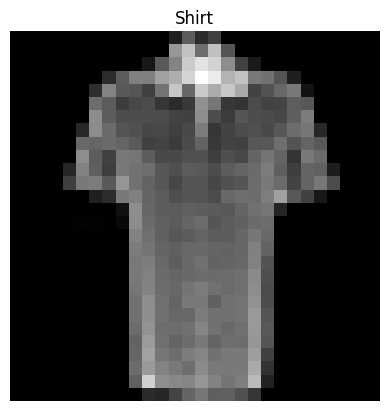

In [17]:
# show a sample

torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size= [1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

print(f"Image size: {img.shape}")
print(f"label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [18]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# flatten the sample
output = flatten_model(x) # perform forward pass

# print out what happened
print(f"Shape before flatting: {x.shape} -> [color_channels, height, width]")

print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flatting: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [19]:
output

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0039, 0.0039, 0.0000, 0.0000, 0.0078, 0.0078,
         0.0000, 0.0000, 0.0039, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.2863, 0.0000, 0.0

In [20]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

torch.manual_seed(42)

# setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape= len(class_names)
)
model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [21]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer and evaluation metrics

- Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
- Optimizer - Our optimizer `torch.optim.SGD()` (stochastic gradient descent)
- Evaluation metric - since we're working on a classification problem, let's use accuracy as our evaluation metric

In [22]:
# Import accuracy metric
from helper_function import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)


### 3.2 Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy value etc)
2. How fast it runs.

In [23]:
from timeit import default_timer as timer
import torch

def print_train_time(start: float, end: float, device = None):
    """Prints difference between start and end time"""
    total_time = end - start
    dev = device if device is not None else "Unknown device"
    print(f"Train time on {dev}: {total_time:.3f} seconds")
    return total_time


### 3.3 Creating a training loop and training a model on batches of data
1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*
4. Print out what's happening.
5. Time it all (for fun).

In [24]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_cpu = timer()

# Training setup
epochs = 3
device = next(model_0.parameters()).device

# Training loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")

    ### Training
    train_loss = 0
    model_0.train()

    for batch, (X, y) in enumerate(train_dataloader):
        # Forward pass
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # accumulate loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test).item()
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)  # ✅ fix for correct averaging

    print(f"\nTraining loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.3f}")

# Measure and print total training time
train_time_end_cpu = timer()
total_train_time_model_0 = print_train_time(
    start=train_time_start_cpu,
    end=train_time_end_cpu,
    device=device
)


c:\Users\bisha\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:15<00:31, 15.83s/it]


Training loss: 0.5904 | Test loss: 0.5095 | Test acc: 82.039
Epoch: 1
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:32<00:16, 16.41s/it]


Training loss: 0.4763 | Test loss: 0.4799 | Test acc: 83.197
Epoch: 2
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:48<00:00, 16.05s/it]


Training loss: 0.4550 | Test loss: 0.4766 | Test acc: 83.427
Train time on cpu: 48.155 seconds


In [25]:
# instanciating model_0
model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape= len(class_names)
)
model_0.to("cuda")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [26]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[-0.0167,  0.0091, -0.0165,  ...,  0.0349, -0.0072,  0.0142],
                      [-0.0319,  0.0206, -0.0111,  ...,  0.0081,  0.0005,  0.0217],
                      [ 0.0023,  0.0029,  0.0097,  ...,  0.0319, -0.0184,  0.0310],
                      ...,
                      [-0.0093,  0.0024,  0.0269,  ..., -0.0069,  0.0233, -0.0008],
                      [-0.0126, -0.0139, -0.0208,  ...,  0.0082,  0.0110,  0.0066],
                      [ 0.0330,  0.0033,  0.0030,  ...,  0.0122, -0.0257, -0.0120]],
                     device='cuda:0')),
             ('layer_stack.1.bias',
              tensor([ 0.0228,  0.0321, -0.0169,  0.0152, -0.0084,  0.0227, -0.0054, -0.0284,
                      -0.0354, -0.0013], device='cuda:0')),
             ('layer_stack.2.weight',
              tensor([[ 0.0932, -0.1864,  0.2488,  0.1500,  0.1907,  0.1457, -0.3050, -0.0580,
                        0.1643,  0.1565],
                      [-0

In [27]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_gpu = timer()

# Training setup
epochs = 3
device = next(model_0.parameters()).device

# Training loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")

    ### Training
    train_loss = 0
    model_0.train()

    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)  # Added this line


        # Forward pass
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # accumulate loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)    

            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test).item()
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)  # ✅ fix for correct averaging

    print(f"\nTraining loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.3f}")

# Measure and print total training time
train_time_end_gpu = timer()
total_train_time_model_0 = print_train_time(
    start=train_time_start_gpu,
    end=train_time_end_gpu,
    device=device
)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:17<00:35, 18.00s/it]


Training loss: 2.3396 | Test loss: 2.3401 | Test acc: 10.523
Epoch: 1
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:35<00:17, 17.77s/it]


Training loss: 2.3396 | Test loss: 2.3401 | Test acc: 10.523
Epoch: 2
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:53<00:00, 17.82s/it]


Training loss: 2.3396 | Test loss: 2.3401 | Test acc: 10.523
Train time on cuda:0: 53.466 seconds


16:27:58

## 4 Make predictions and get Model 0 results

In [28]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Evaluates a model on a given dataset."""
    loss, acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            # Move data to the same device as model
            X, y = X.to(device), y.to(device)
            
            # Make predictions
            y_pred = model(X)

            # Calculate loss and accuracy
            loss += loss_fn(y_pred, y).item()
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

    # Calculate average
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss,
            "model_acc": acc}


# Calculate the model_0 result on test datasets
model_0_results = eval_model(model= model_0,
                             data_loader= test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 2.3401436706701406,
 'model_acc': 10.523162939297125}

## 5. Setup device agnostic code

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linearity

We learnt about the power of non-linearity in notebook 02 - https://www.learnpytorch.io/02_pytorch_classification/#6-the-missing-piece-non-linearity

In [30]:
# Create a model with non-linear and linear layers

class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        self.layers_stack = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_shape),
            nn.ReLU()
        )

    def forward(self, x:torch.Tensor) ->torch.Tensor:
        return self.layers_stack(x)

In [31]:
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(input_shape= 784,
                              hidden_units= 10,
                              output_shape= len(class_names)).to(device)
model_1.to(device)

FashionMNISTModelV1(
  (layers_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [32]:
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.1 Setup loss, optimizer and evaluation metrics

In [33]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params= model_1.parameters(), lr=0.1)

### 6.2 Functionizing training and evaluation/testing loop

Let's create a function for:
- training loop - `train_step()`
- testing loop - `test_step()`

Date: 2082-02-29
Time: 1:30 pm

In [34]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device
               ):
    train_loss, train_acc = 0, 0

    # Put model into training model
    model.train()

    # Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(data_loader):
        # Put data on target device

        X,y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate Loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulates train loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Divide total train loss and acc by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f}    |   Train acc: {train_acc:.3f}%") 

In [35]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # 1. Forward pass (logits)
            test_pred = model(X)

            # 2. Calculate the loss correctly
            loss = loss_fn(test_pred, y)  # ✅ raw logits + labels
            test_loss += loss

            # 3. Calculate accuracy separately
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

        # 4. Average metrics
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test loss: {test_loss:.5f}  |   Test acc: {test_acc:.2f}%\n")


In [36]:
device

'cuda'

In [37]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_gpu = timer()

# Set epochs
epochs = 3

# create an optimization and evaluation loop using train_step and test step
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n -------")
    train_step(model= model_1,
               data_loader=train_dataloader,
                loss_fn = loss_fn,
                optimizer= optimizer,
                 accuracy_fn= accuracy_fn,
                  device= device )
    test_step(model= model_1,
               data_loader=test_dataloader,
                loss_fn = loss_fn,
                 accuracy_fn= accuracy_fn,
                  device= device)
    
train_time_end_gpu = timer()

total_train_time_model_1 = print_train_time(start=train_time_start_gpu, end=train_time_end_gpu)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
 -------
Train loss: 1.09199    |   Train acc: 61.343%


 33%|███▎      | 1/3 [00:19<00:38, 19.21s/it]

Test loss: 0.95636  |   Test acc: 65.00%

Epoch: 1
 -------
Train loss: 0.78101    |   Train acc: 71.928%


 67%|██████▋   | 2/3 [00:37<00:18, 18.86s/it]

Test loss: 0.72227  |   Test acc: 73.91%

Epoch: 2
 -------
Train loss: 0.67027    |   Train acc: 75.937%


100%|██████████| 3/3 [00:56<00:00, 18.85s/it]

Test loss: 0.68500  |   Test acc: 75.02%

Train time on Unknown device: 56.547 seconds


In [38]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 2.3401436706701406,
 'model_acc': 10.523162939297125}

In [39]:
# Calculate the model_1 result on test datasets
model_1_results = eval_model(model= model_1,
                             data_loader= test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850009760536706,
 'model_acc': 75.01996805111821}

## Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConVets.

CNN's are known for their capabilities to find patterns in visual data.

To find what's happening, see this website https://poloclub.github.io/cnn-explainer/

17:32:03

I got the error:

**RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1960 and 490x10)**

In [40]:
# # Create a Convolutional Neural Network

# 🖐️🖐️ Maile Lekheko Code. But due to some errors i used ChatGPT to get the solution and below is the solution by chatgpt. It said that 

# class FashionMNISTModelV2(nn.Module): 
#     """
#     Model Architecture that replicates the TinyVGG model from CNN explainer website.
#     """

#     def __init__(self, input_shape: int,
#                  hidden_units: int,
#                  output_shape: int):
#         super().__init__()

#         self.conv_block_1 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels=input_shape,
#                 out_channels= hidden_units,
#                 kernel_size=3,
#                 stride=1,
#                 padding=1
#                 ), # values that we can set ourselves in our NN's are called hyperparameters.
#             # nn.MaxPool2d()
#             nn.ReLU(),
#             nn.Conv2d(
#                 in_channels=hidden_units,
#                 out_channels= hidden_units,
#                 kernel_size=3,
#                 stride=1,
#                 padding=1
#                 ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.conv_block_2 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels= hidden_units,
#                 out_channels= hidden_units,
#                 kernel_size=3,
#                 stride=1,
#                 padding=1),
#                 nn.ReLU(),
#             nn.Conv2d(
#                 in_channels= hidden_units,
#                 out_channels= hidden_units,
#                 kernel_size=3,
#                 stride=1,
#                 padding=1),
#                 nn.ReLU(),
#         )

#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_features= hidden_units*7*7, # Something's crazy here🤯
#                       out_features=output_shape)
#         )

#     def forward(self, x: torch.Tensor)->torch.Tensor:
#         x = self.conv_block_1(x)
#         # print(f"Output shape of conv_block_1: {x.shape}")
#         x = self.conv_block_2(x)
#         # print(f"Output shape of conv_block_2: {x.shape}")
#         x = self.classifier(x)
#         # print(f"Output shape of classifier: {x.shape}")
#         return x

class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
        )

        # We'll determine the in_features dynamically
        self._dummy_input = torch.randn(1, input_shape, 28, 28)
        self._out_shape = self._get_flattened_shape(self._dummy_input, hidden_units)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._out_shape, output_shape)
        )

    def _get_flattened_shape(self, x, hidden_units):
        with torch.no_grad():
            x = self.conv_block_1(x)
            x = self.conv_block_2(x)
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [41]:
torch.manual_seed(42)

model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=10, bias=True)
  )
)

### 7.1 Stepping through `nn.Conv2d()`

See the documentation for nn.Conv2d() here - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [42]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size= (32,3,64,64))
test_image = images[0]

print(f"Image batch shape: {image.shape}")
print(f"single image shape: {test_image.shape}")
print(f"Test image: {test_image}")

Image batch shape: torch.Size([1, 28, 28])
single image shape: torch.Size([3, 64, 64])
Test image: tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.7978

In [43]:
test_img_permuted = test_image.permute(2,1,0)
test_img_permuted.shape

torch.Size([64, 64, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.8325317..4.2208853].


(-0.5, 63.5, 63.5, -0.5)

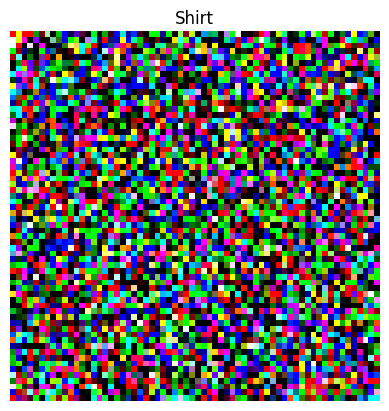

In [44]:
import matplotlib.pyplot as plt

plt.imshow(test_img_permuted.squeeze(),cmap="gray") # matplotlib expects the image to be in color channel last format. but our data has color channel last. Here we have the grayscaled image whose color channel is 1 so we remove the color channel. if we had color channel that is greater than one we have to use permute.

plt.title(class_names[label])
plt.axis(False)

In [45]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [46]:
torch.manual_seed(42)

# Create a single conv2d layer
conv_layer = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    padding=0,
    stride=1)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image)
print(f"Conv output shape: {conv_output.shape}")
conv_output

Conv output shape: torch.Size([10, 62, 62])


tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

### 7.2 Setup a loss function and optimizer for model_2


In [47]:
from helper_function import accuracy_fn
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

### 7.3 Train and Test loop

In [48]:
torch.manual_seed(42)
train_time_start_gpu = timer()

epochs = 3

# Changed model_0 to model_2 in both training and testing steps
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    
    train_step(
        model=model_2,  # Changed from model_0 to model_2
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    
    test_step(
        model=model_2,  # Changed from model_0 to model_2
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_gpu = timer()
total_train_time_model_2 = print_train_time(  # Changed variable name to reflect model_2
    start=train_time_start_gpu,
    end=train_time_end_gpu,
    device=device
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.53769    |   Train acc: 80.448%


 33%|███▎      | 1/3 [00:24<00:48, 24.10s/it]

Test loss: 0.39600  |   Test acc: 85.58%

Epoch: 1
-------
Train loss: 0.35467    |   Train acc: 87.110%


 67%|██████▋   | 2/3 [00:47<00:23, 23.40s/it]

Test loss: 0.35738  |   Test acc: 86.85%

Epoch: 2
-------
Train loss: 0.31887    |   Train acc: 88.488%


100%|██████████| 3/3 [01:10<00:00, 23.48s/it]

Test loss: 0.32341  |   Test acc: 88.23%

Train time on cuda: 70.433 seconds


In [49]:
# Calculate the model_2 result on test datasets
model_2_results = eval_model(model= model_2,
                             data_loader= test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32341116047895757,
 'model_acc': 88.22883386581469}

## 8. Compare model results and training time

In [50]:
import pandas as pd

compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,2.340144,10.523163
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.323411,88.228834


In [51]:
compare_results['model_train_time'] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]

In [52]:
compare_results

,model_name,model_loss,model_acc,model_train_time
0,FashionMNISTModelV0,2.340144,10.523163,53.466190
1,FashionMNISTModelV1,0.685001,75.019968,56.546840
2,FashionMNISTModelV2,0.323411,88.228834,70.433245


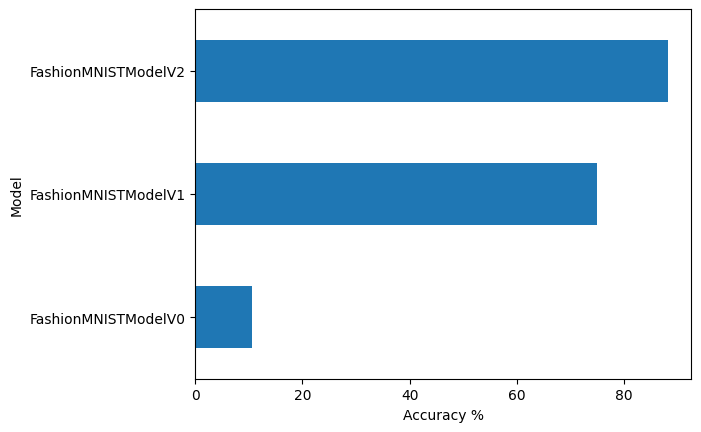

In [53]:
# Visualize our model accuracies

compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy %")
plt.ylabel("Model")
plt.show()

## 9. Make and evaluate random predictions with best model

In [59]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample
            sample = torch.unsqueeze(sample,dim=0).to(device)


            # Forward pass (model outputs raw logits)
            pred_logits = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logits.squeeze(),dim=0)

            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

        # Stack the pred_probs to turn list into a tensor
        return torch.stack(pred_probs)

In [60]:
import random
random.seed(42)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)  # FIXED: Don't convert to list
    test_labels.append(label)

# Now this works
test_samples[0].shape


torch.Size([1, 28, 28])

Text(0.5, 1.0, '5')

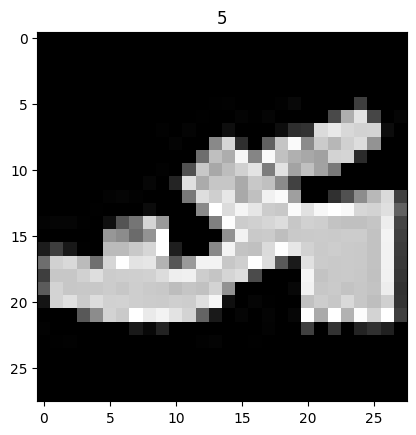

In [61]:
plt.imshow(test_samples[0].squeeze(),cmap="gray")
plt.title(test_labels[0])

In [62]:
# Make Predictions
pred_probs = make_predictions(
    model=model_2,
    data=test_samples
)

pred_probs[:3]

tensor([[1.0311e-06, 1.7067e-08, 7.7708e-07, 9.7504e-08, 9.9642e-08, 9.9830e-01,
         9.9817e-06, 3.2533e-06, 4.2459e-05, 1.6461e-03],
        [2.1259e-01, 1.0156e-01, 5.1035e-03, 3.5567e-01, 2.5703e-01, 4.4012e-04,
         6.4656e-02, 8.9260e-04, 1.8874e-03, 1.7032e-04],
        [4.4316e-06, 1.7015e-07, 5.6838e-06, 1.7085e-06, 1.9417e-06, 2.1909e-04,
         1.8808e-05, 8.3884e-01, 1.8020e-04, 1.6072e-01]])

In [65]:
# convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 3, 7, 4, 3, 0, 4, 7, 1])

In [66]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

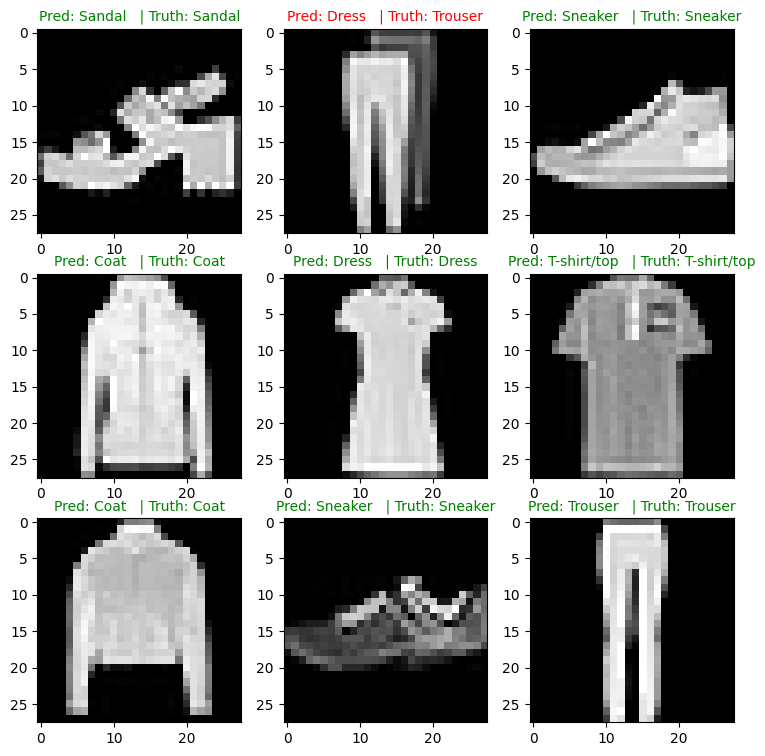

In [ ]:
# Plot predictions

plt.figure(figsize=(9,9))
nrows, ncols = 3,3
for i, sample in enumerate(test_samples):
    #create subplot
    plt.subplot(nrows,ncols,i+1)

    # plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction (in text form e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label}   | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text,fontsize=10, c="r")

    plt.axis(False)

### 10. Making a Confusion Matrix for further prediction evaluation

A confusion martrix is the fantasic way of evaluating your clasification models visually. - https://www.learnpytorch.io/02_pytorch_classification/#9-more-classification-evaluation-metrics

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix` - https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html
3. Plot the confusion matrix using mlxtend.plotting.plot_confusion_matrix() - http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

In [73]:
import mlxtend
mlxtend.__version__

'0.23.4'

In [78]:
# import tqdm.auto

from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()

with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send the data and targets to target device
        X,y = X.to(device), y.to(device)

        # Do the forward pass
        y_logits = model_2(X)

        #Turn predictions from logits -> prediction probabilities -> prediction labels
        y_pred = torch.softmax(y_logits.squeeze(),dim=0).argmax(dim=1)

        # put the prediction on CPU for evaluations
        y_preds.append(y_pred.cpu())

        # concatenate list of predictions into tensors
        # print(y_preds)
        y_preds_tensors = torch.cat(y_preds)
        y_preds_tensors


Making predictions...: 100%|██████████| 313/313 [00:02<00:00, 116.33it/s]


In [79]:
len(y_preds_tensors)

10000

In [80]:
mlxtend.__version__

'0.23.4'

In [82]:
class_names, len(class_names)

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 10)

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task= "multiclass",
    num_classes= len(class_names)
)
confmat_tensor = confmat(preds= y_preds_tensors,
                         target= test_data.targets)


In [85]:
confmat_tensor

tensor([[746,   5,  29,  54,  10,   0, 153,   0,   3,   0],
        [ 11, 887,  11,  65,  19,   0,   5,   0,   2,   0],
        [ 12,   4, 767,  12, 113,   0,  87,   0,   5,   0],
        [ 39,   5,  41, 828,  47,   0,  35,   0,   5,   0],
        [  8,   5, 131,  44, 715,   0,  92,   0,   5,   0],
        [  7,   1,   2,   1,   1, 875,   4,  35,  48,  26],
        [129,   4, 101,  49,  99,   0, 610,   0,   8,   0],
        [  1,   0,   0,   0,   0,  27,   0, 908,  14,  50],
        [ 15,   2,  26,  11,  11,   7,  27,   6, 893,   2],
        [  0,   0,   0,   2,   0,  23,   2,  84,  20, 869]])

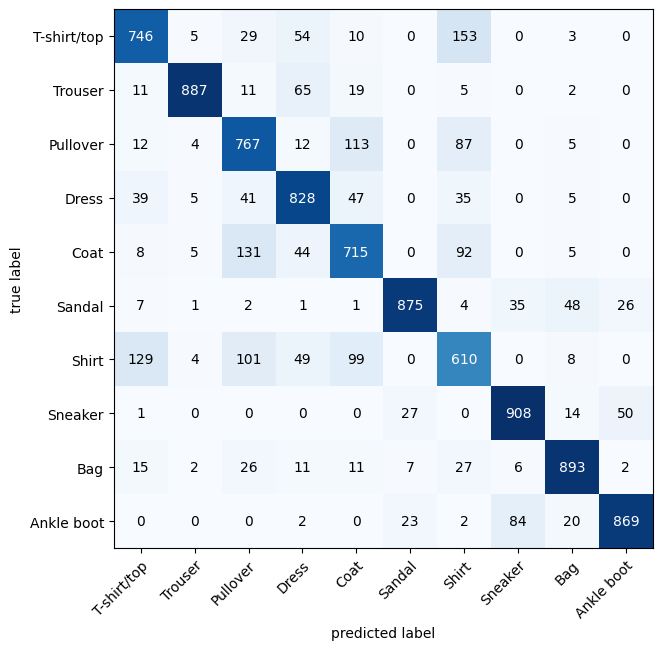

In [86]:
# 3. plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat= confmat_tensor.numpy(),
    class_names= class_names,
    figsize=(10,7)
)

## 11. Save and load our best performing model

In [87]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create a model save path
MODEL_NAME = "0_3_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f= MODEL_SAVE_PATH)

Saving model to: models\0_3_pytorch_computer_vision_model_2.pth


In [ ]:
# Create a new instance

torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=10
)

# Loaded in the save state dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2.to(device)

C:\Users\bisha\AppData\Local\Temp\ipykernel_17648\2215663202.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=10, bias=True)
  )
)

In [89]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32341116047895757,
 'model_acc': 88.22883386581469}

In [90]:
# Evaluate loaded model
from torch import manual_seed


torch,manual_seed(42)

loaded_model_2_results = eval_model(model= loaded_model_2,
                                    data_loader= test_dataloader,
                                    loss_fn= loss_fn,
                                    accuracy_fn=accuracy_fn,)
loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32341116047895757,
 'model_acc': 88.22883386581469}

In [93]:
# Check if model results are close to each other.
torch.isclose(
    torch.tensor(model_2_results["model_loss"]),
    torch.tensor(loaded_model_2_results['model_loss']),
    atol=0.2
)

tensor(True)